In [1]:
import pathlib

import cdflib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.constants
import torch
from cdasws import CdasWs

from pymfr.detect import detect_flux_ropes

In [2]:
time = ['2016-01-01T00:00:00Z', '2016-01-02T00:00:00Z']

file_name = f"./data/wind_{time[0]}_{time[1]}_1min_nonlin.npz"
if not pathlib.Path(file_name).exists():
    cdas = CdasWs()

    status, data = cdas.get_data('WI_H1_SWE', ['Proton_VX_nonlin',
                                               'Proton_VY_nonlin',
                                               'Proton_VZ_nonlin',
                                               'Proton_Np_nonlin',
                                               'Proton_W_nonlin'],
                                 time[0], time[1])

    datetime = cdflib.epochs.CDFepoch().to_datetime(data.Epoch.values, to_np=True)

    velocity = np.column_stack([data.Proton_VX_nonlin.values,
                                data.Proton_VY_nonlin.values,
                                data.Proton_VZ_nonlin.values])
    velocity[np.any(velocity == data.Proton_VX_nonlin.FILLVAL, axis=1)] = np.nan
    velocity[np.any(velocity == data.Proton_VY_nonlin.FILLVAL, axis=1)] = np.nan
    velocity[np.any(velocity == data.Proton_VZ_nonlin.FILLVAL, axis=1)] = np.nan
    velocity = pd.DataFrame(velocity, index=pd.DatetimeIndex(datetime)).interpolate()
    velocity = velocity.resample("60s").mean().shift(0.5, freq="60s").interpolate()
    times = velocity.index.values

    density = data.Proton_Np_nonlin.values
    density[density == data.Proton_Np_nonlin.FILLVAL] = np.nan
    density = pd.Series(density, index=pd.DatetimeIndex(datetime)).interpolate()
    density = density.resample("60s").mean().shift(0.5, freq="60s").interpolate()

    temperature = data.Proton_W_nonlin.values
    temperature[temperature == data.Proton_W_nonlin.FILLVAL] = np.nan
    temperature = (temperature * 1e3) ** 2 * scipy.constants.m_p / (2 * scipy.constants.Boltzmann) / 1e6
    temperature = pd.Series(temperature, index=pd.DatetimeIndex(datetime)).interpolate()
    temperature = temperature.resample("60s").mean().shift(0.5, freq="60s").interpolate()

    status, data = cdas.get_data('WI_H0_MFI', ['BGSE'], time[0], time[1])

    magnetic_field = data.BGSE.values
    magnetic_field[np.any(magnetic_field == data.BGSE.FILLVAL, axis=1), :] = np.nan
    datetime = cdflib.epochs.CDFepoch().to_datetime(data.Epoch.values, to_np=True)
    magnetic_field = pd.DataFrame(magnetic_field, index=pd.DatetimeIndex(datetime)).interpolate()

    magnetic_field = magnetic_field.truncate(times[0], times[-1])
    density = density.truncate(magnetic_field.index[0], magnetic_field.index[-1]).values
    temperature = temperature.truncate(magnetic_field.index[0], magnetic_field.index[-1]).values
    velocity = velocity.truncate(magnetic_field.index[0], magnetic_field.index[-1]).values
    times = magnetic_field.index.values

    assert len(magnetic_field) == len(velocity) == len(density)

    np.savez_compressed(file_name, magnetic_field=magnetic_field, velocity=velocity, density=density, temperature=temperature, times=times)

data = np.load(file_name)

magnetic_field = torch.as_tensor(data["magnetic_field"], dtype=torch.float32)
velocity = torch.as_tensor(data["velocity"], dtype=torch.float32)
density = torch.as_tensor(data["density"], dtype=torch.float32)
temperature = torch.as_tensor(data["temperature"], dtype=torch.float32)
times = data["times"]

In [3]:
durations = range(10, 360)

gas_pressure = scipy.constants.Boltzmann * (density * 1e6) * (temperature * 1e6) * 1e9

results = detect_flux_ropes(magnetic_field, velocity, density, gas_pressure,
                            batch_size_mb=4096,
                            window_steps=[max(duration // 16, 1) for duration in durations],
                            window_lengths=durations, min_strength=5, frame_type="mean_velocity")

100%|██████████| 350/350 [00:32<00:00, 10.94it/s]


2016-01-01T00:09:30.000000000  to  2016-01-01T00:19:30.000000000
duration: 11
error: 0.094 0.083
walen slope: -0.001
<B>: 14.9
Altitude/azimuth: 30 / 160


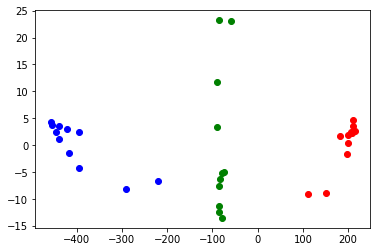

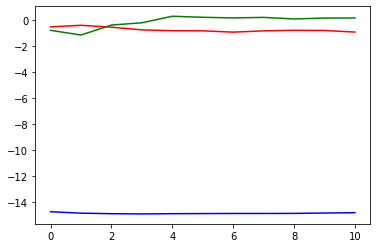

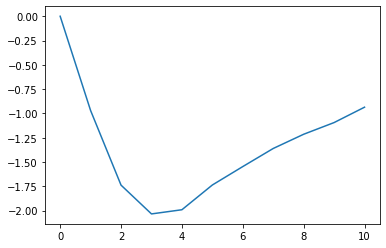

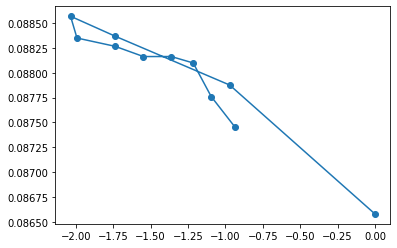

2016-01-01T00:55:30.000000000  to  2016-01-01T01:08:30.000000000
duration: 14
error: 0.097 0.134
walen slope: -0.0
<B>: 14.33
Altitude/azimuth: 80 / 5


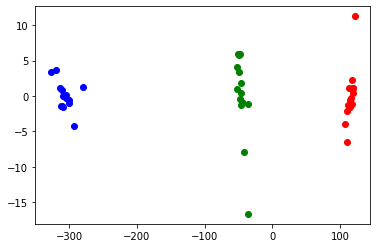

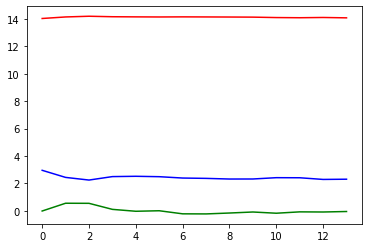

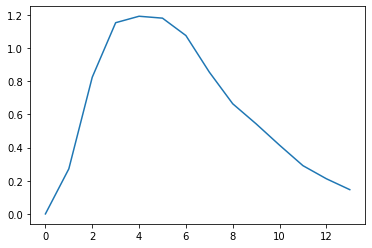

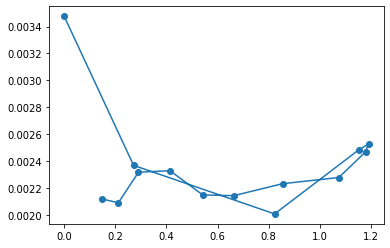

2016-01-01T01:36:30.000000000  to  2016-01-01T01:46:30.000000000
duration: 11
error: 0.099 0.085
walen slope: -0.001
<B>: 13.94
Altitude/azimuth: 15 / 75


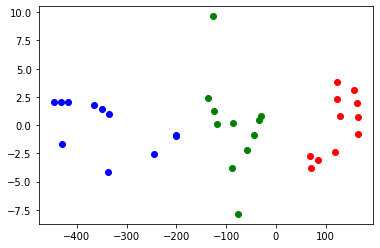

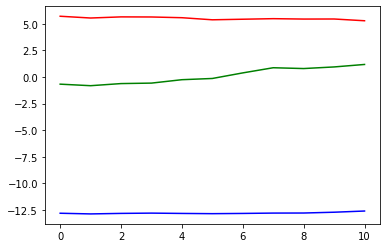

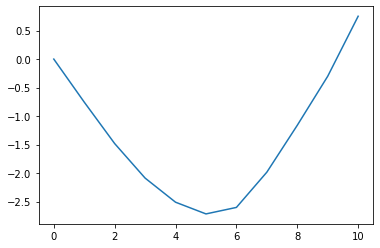

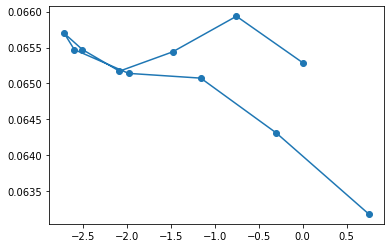

2016-01-01T02:21:30.000000000  to  2016-01-01T02:37:30.000000000
duration: 17
error: 0.073 0.104
walen slope: 0.002
<B>: 13.53
Altitude/azimuth: 15 / 0


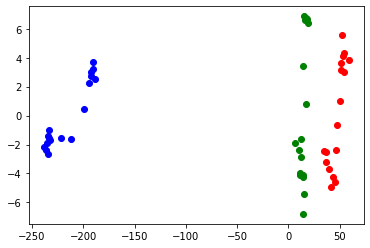

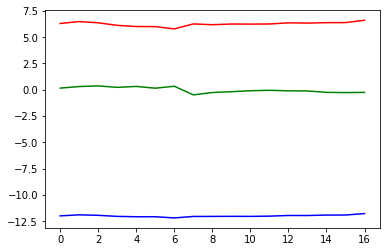

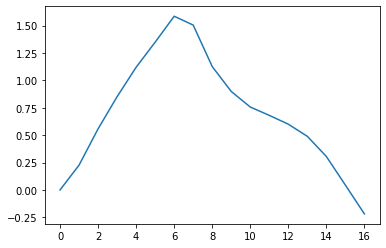

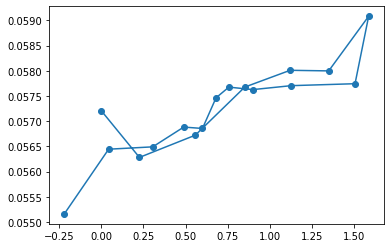

2016-01-01T03:05:30.000000000  to  2016-01-01T03:15:30.000000000
duration: 11
error: 0.108 0.069
walen slope: -0.0
<B>: 13.27
Altitude/azimuth: 35 / 190


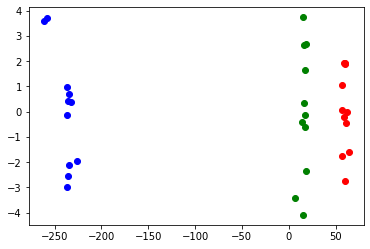

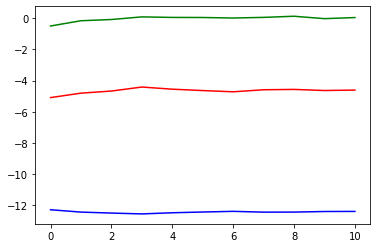

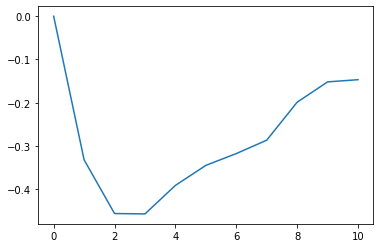

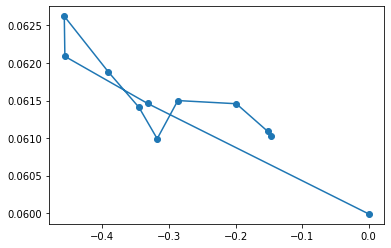

2016-01-01T04:13:30.000000000  to  2016-01-01T06:11:30.000000000
duration: 119
error: 0.12 0.107
walen slope: 0.02
<B>: 11.0
Altitude/azimuth: 60 / 35


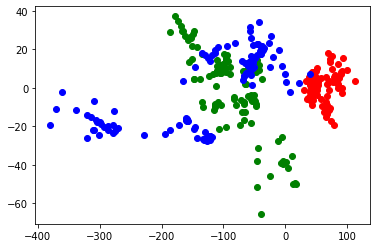

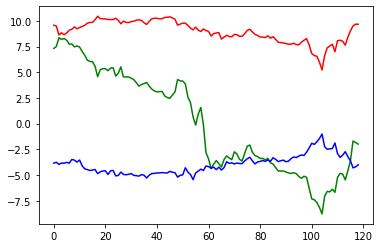

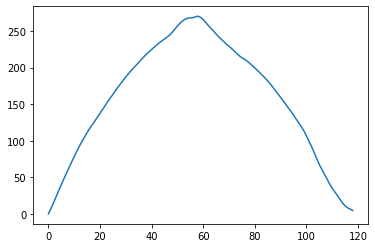

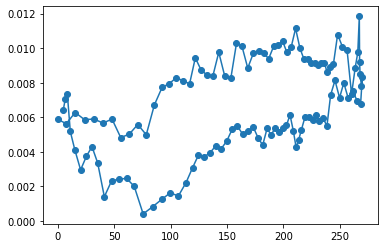

2016-01-01T06:28:30.000000000  to  2016-01-01T07:15:30.000000000
duration: 48
error: 0.09 0.124
walen slope: -0.001
<B>: 10.91
Altitude/azimuth: 35 / 120


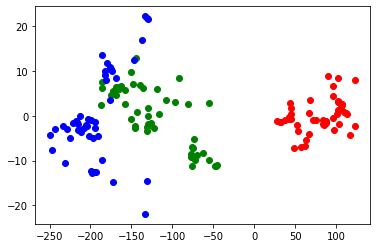

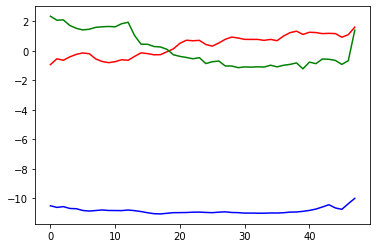

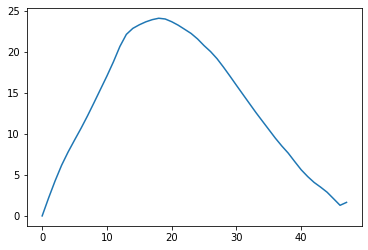

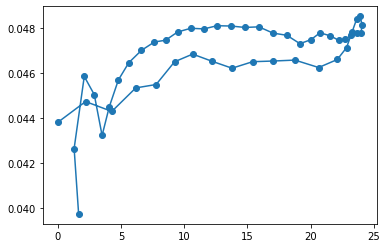

2016-01-01T07:16:30.000000000  to  2016-01-01T07:35:30.000000000
duration: 20
error: 0.097 0.127
walen slope: -0.012
<B>: 10.42
Altitude/azimuth: 35 / 120


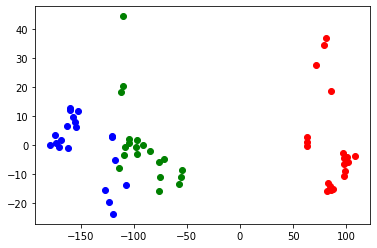

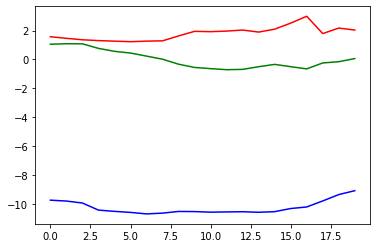

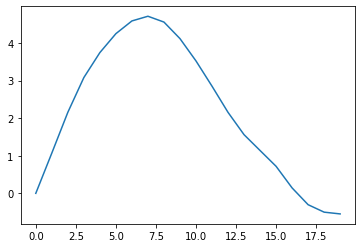

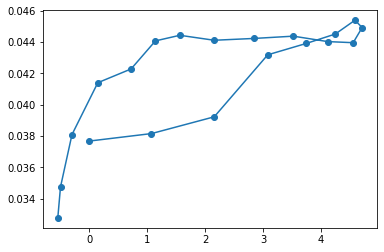

2016-01-01T07:46:30.000000000  to  2016-01-01T11:45:30.000000000
duration: 240
error: 0.118 0.1
walen slope: -0.022
<B>: 9.75
Altitude/azimuth: 85 / 290


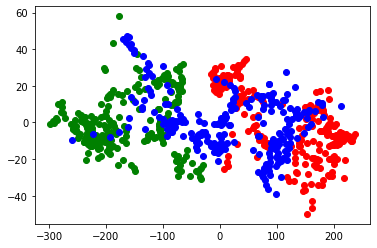

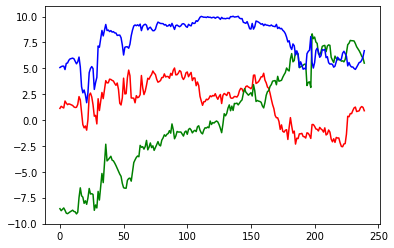

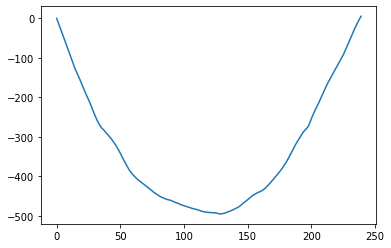

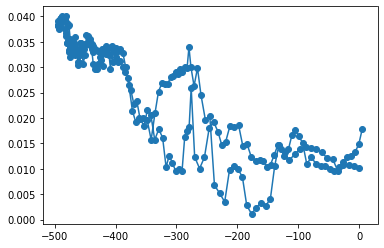

2016-01-01T12:01:30.000000000  to  2016-01-01T12:41:30.000000000
duration: 41
error: 0.09 0.103
walen slope: 0.012
<B>: 9.79
Altitude/azimuth: 85 / 160


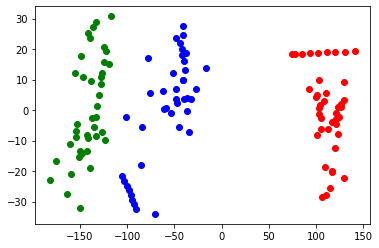

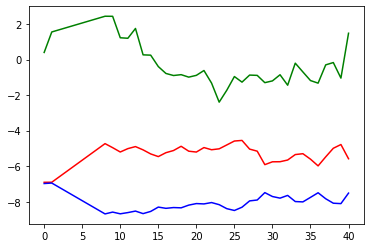

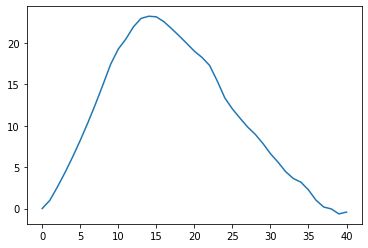

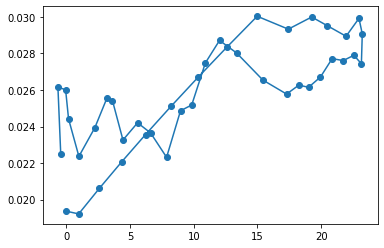

2016-01-01T12:44:30.000000000  to  2016-01-01T13:02:30.000000000
duration: 19
error: 0.119 0.126
walen slope: 0.001
<B>: 9.38
Altitude/azimuth: 75 / 315


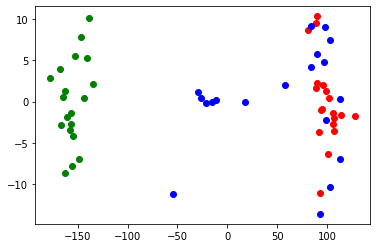

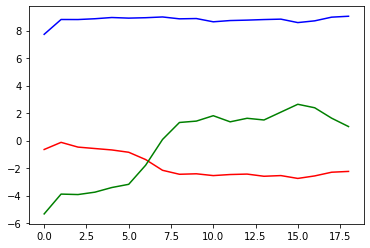

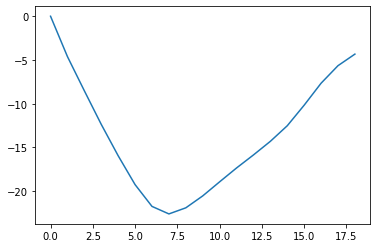

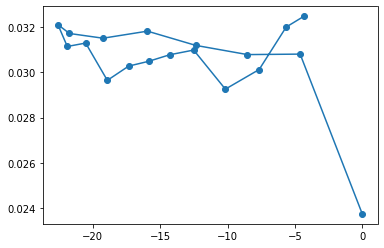

2016-01-01T13:32:30.000000000  to  2016-01-01T13:52:30.000000000
duration: 21
error: 0.093 0.132
walen slope: -0.0
<B>: 9.17
Altitude/azimuth: 80 / 135


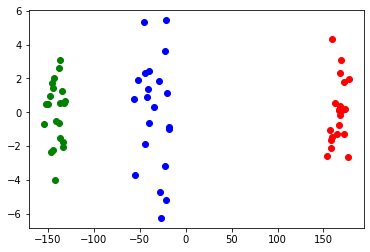

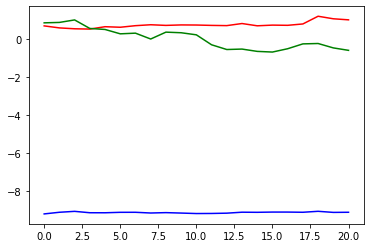

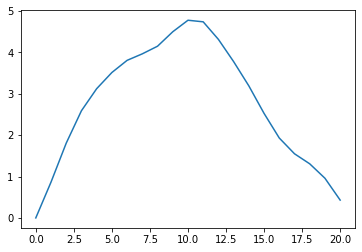

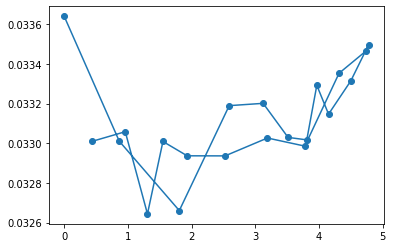

2016-01-01T15:38:30.000000000  to  2016-01-01T15:48:30.000000000
duration: 11
error: 0.119 0.139
walen slope: 0.003
<B>: 8.92
Altitude/azimuth: 80 / 310


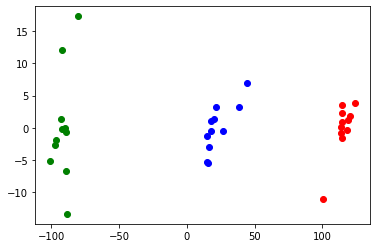

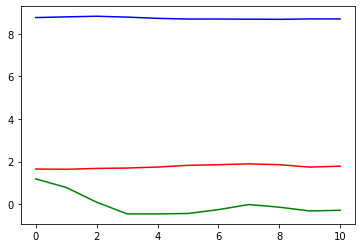

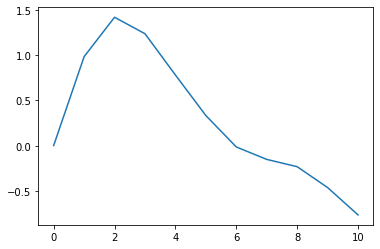

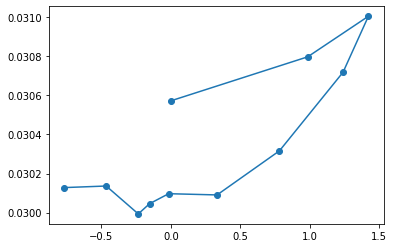

2016-01-01T16:11:30.000000000  to  2016-01-01T16:21:30.000000000
duration: 11
error: 0.053 0.071
walen slope: 0.004
<B>: 8.27
Altitude/azimuth: 85 / 120


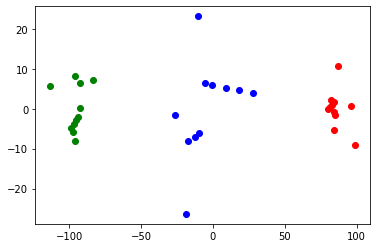

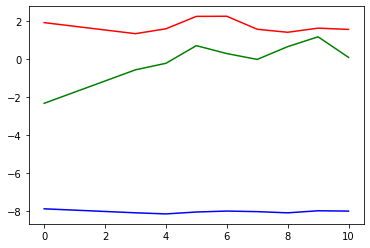

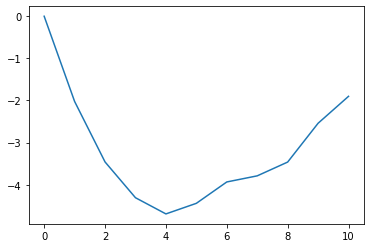

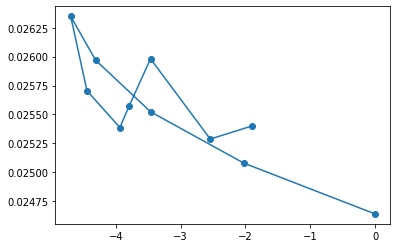

2016-01-01T16:29:30.000000000  to  2016-01-01T16:40:30.000000000
duration: 12
error: 0.111 0.132
walen slope: 0.049
<B>: 8.02
Altitude/azimuth: 85 / 30


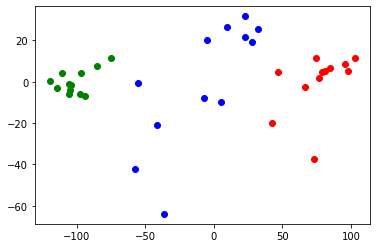

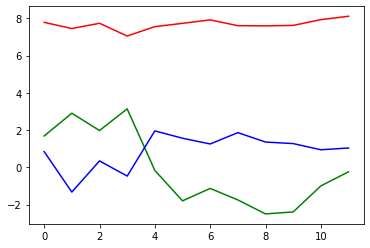

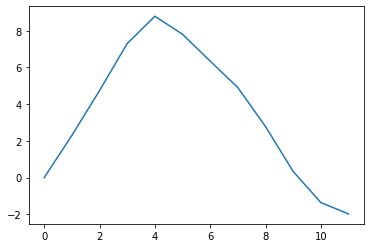

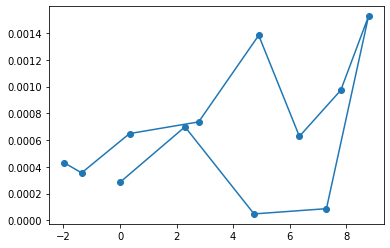

2016-01-01T19:16:30.000000000  to  2016-01-01T22:22:30.000000000
duration: 187
error: 0.102 0.125
walen slope: 0.094
<B>: 5.36
Altitude/azimuth: 70 / 260


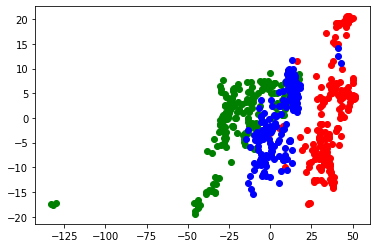

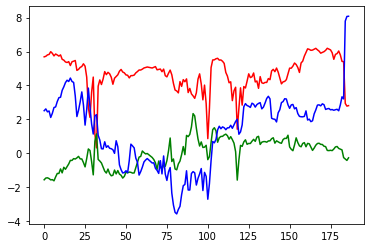

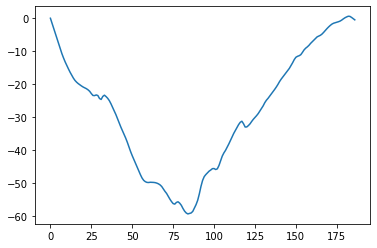

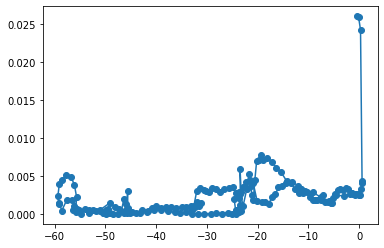

In [4]:
def spherical(x, y, z):
    altitude = np.rad2deg(np.arctan2(np.sqrt(x ** 2 + y ** 2), z))
    azimuth = np.rad2deg(np.arctan2(y, x))
    return altitude, azimuth


for residue, start, end, duration, axis, frame, error_fit in results:
    z_unit = np.array(axis)
    frame = np.array(frame)

    event_velocity = velocity[start:start + duration].cpu().numpy()
    event_field = magnetic_field[start:start + duration].cpu().numpy()

    x_unit = -(frame - np.dot(frame, z_unit) * z_unit)
    x_unit = x_unit / np.linalg.norm(x_unit)
    y_unit = np.cross(z_unit, x_unit)
    rotation_matrix = np.column_stack([x_unit, y_unit, z_unit])
    rotation_matrix = rotation_matrix.T  # transpose gives inverse of rotation matrix

    event_density = density[start:start + duration].cpu().numpy()

    alfven_velocity = event_field / np.sqrt(scipy.constants.mu_0
                                            * scipy.constants.m_p
                                            * np.expand_dims(event_density, axis=1)) * 1e-15
    Pgas = gas_pressure[start:start + duration].cpu().numpy()
    remaining_flow = event_velocity - frame

    d_flow = remaining_flow - remaining_flow.mean()
    d_alfven = alfven_velocity - alfven_velocity.mean()
    walen_slope = (d_flow * d_alfven).sum() / (d_alfven ** 2).sum()

    # if walen_slope > 0.3:
    #     continue

    print(times[start], " to ", times[end])
    print("duration:", duration)
    print("error:", round(residue, 3), round(error_fit, 3))
    print("walen slope:", round(walen_slope, 3))
    print("<B>:", round(np.linalg.norm(event_field, axis=1).mean(), 2))
    altitude, azimuth = spherical(*axis)
    print("Altitude/azimuth:", round(altitude), "/", round(azimuth % 360))

    colors = ["red", "green", "blue"]

    for i_color, color in enumerate(colors):
        plt.scatter(alfven_velocity[:, i_color], remaining_flow[:, i_color], color=color)
    plt.show()

    rotated = rotation_matrix @ event_field.T
    for i_color, color in enumerate(colors):
        plt.plot(rotated[i_color], color=color)
    plt.show()

    A = scipy.integrate.cumulative_trapezoid(rotated[1], initial=0)
    plt.plot(A)
    plt.show()

    P = Pgas = (rotated[2] * 1e-9) ** 2 / (2 * 1.25663706212e-6) * 1e9
    plt.scatter(A, P)
    plt.plot(A, P)
    plt.show()